# Exploring dimensionless numbers and Neural Network Regression
Author: Payam Mousavi  
Last updated: March 8, 2024 

Given the analytical equation (fitted empirically) for the Drag Coefficient $C_D$ provided in reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf, we see that it's only a function of the Reynolds number, $Re = \rho.U.D/\mu$. Let's say that we did not know this ahead of time and wanted to perform experiments for a range of input parameters, namely, $\rho$, $U$, $D$, and $\mu$. Clearly, many combinations will be redundant since they correpond to the same $Re$. Consider the following models:  

Given $\rho$, $U$, $D$, and $\mu$, consider the following models: 


<img src="./Figures/Model_0.png" width="300" height="200" /> . 

This is the simplest model that takes into account the known physics that Re is the relevant feature that is predictive of $C_D$.  
In this notebook:  
* Create datasets (of varying sizes) with the feature Re and target the calculated values of $C_D$.  
* Sample Re uniformly.  
* Fit and assess fit quality. Note that Re needs to be scaled before fitting the model.  









In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


from utils import *
from models import Model_II, Model_0
from datasets import *
from train import train_model
from predict import predict_model
from eval import eval_model

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from tqdm import tqdm
import pandas as pd
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import torch.nn.init as init
from torch.utils.tensorboard import SummaryWriter

matplotlib.rcParams.update({'font.size': 18})
eps = 1e-12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Re_vec = np.logspace(2, 7, 1000)
# rho, mu, D, U = generate_inputs_from_Re(Re_vec=Re_vec, u_range=[0.1, 1e3], rho_range=[1, 1000], mu_range=[1e-3, 1e3], D_range=[1e-3, 1e3])
# # rho# 

In [21]:
def plot_CD(Re, CD, marker='o'):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=Re, y=CD, color='blue', marker=marker, alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$Re$')
    plt.ylabel('$C_D$')

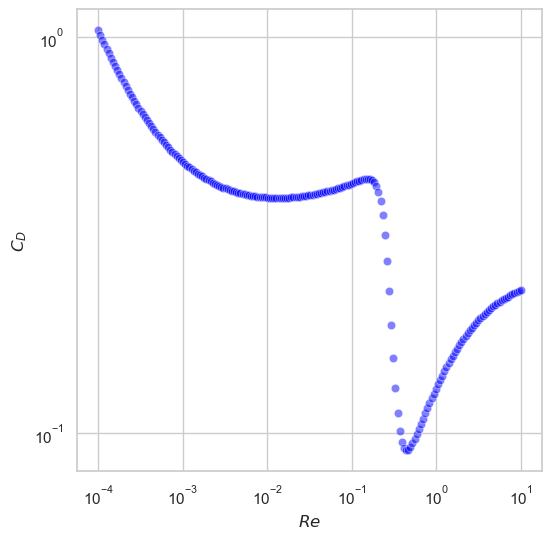

In [13]:
Re_vec = np.logspace(2, 7, 200)
# Re_vec = np.linspace(1e1, 1e7, 1000)
CDs, _ = run_experiments(Re_vec=Re_vec)

Re_vec_rescaled = Re_vec/1e6
plot_CD(Re_vec_rescaled, CDs, marker='o')

## Dataset Creation 

### 1-input dataset:

In [22]:
# Create the dataloader/dataset:
dataset = RandomDataset_Re(num_samples=50000,
                           Re_range=[1e3, 1e7], #NOTE: Increasing the range might result in much worse fits!
                           re_scaling=1e6,
                           seed=123)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)

# Extract Re values for test set (used for visualizing histograms):
test_Re = []
for re, _ in test_dataset:
    test_Re.append(re.item())

test_Re = np.array(test_Re)

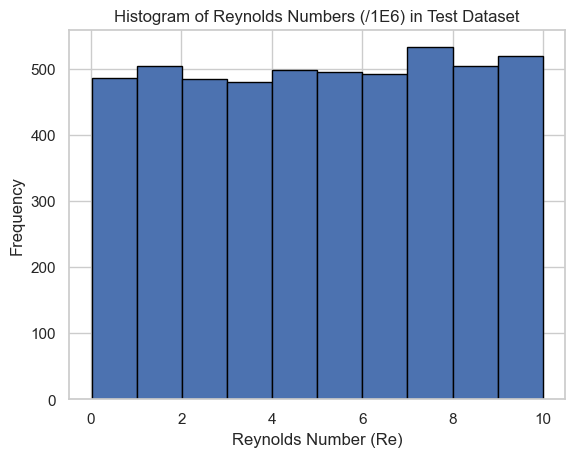

(0.015628531575202942, 9.996442794799805)

In [23]:
plt.hist(test_Re, bins=10, edgecolor='black')
plt.xlabel('Reynolds Number (Re)')
plt.ylabel('Frequency')
plt.title('Histogram of Reynolds Numbers (/1E6) in Test Dataset')
plt.savefig('Figures/Model_0-Re_histogram.png')
plt.show()

min(test_Re), max(test_Re)

# Training

### Model_0:

In [24]:
# Setting up the model:
HIDDEN_DIMS = [64, 32, 16, 8, 4]
MODEL_NAME = 'Model_0'
MODEL = Model_0(input_dim=1, output_dim=1, hidden_dims=HIDDEN_DIMS).float()
CRITERION = nn.MSELoss() # criterion = nn.L1Loss(), nn.SmoothL1Loss(), ...
OPTIMIZER = Adam(MODEL.parameters(), lr=1e-3)
WRITER = SummaryWriter('runs/' + MODEL_NAME)
MODEL_SAVE_PATH = 'models/' + MODEL_NAME + '.pt'
WRITER_PATH = 'runs/' + MODEL_NAME

NUM_EPOCHS = 100

num_trainable_params = sum(p.numel() for p in MODEL.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 2913


Epoch 1/100, Train Loss: 0.0425, Validation Loss: 0.0330
Epoch 2/100, Train Loss: 0.0238, Validation Loss: 0.0042
Epoch 3/100, Train Loss: 0.0011, Validation Loss: 0.0005
Epoch 4/100, Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 5/100, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 6/100, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 7/100, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 8/100, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 9/100, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 10/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 11/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 12/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 13/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 14/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 15/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 16/100, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 17/100, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 18/100, Train Los

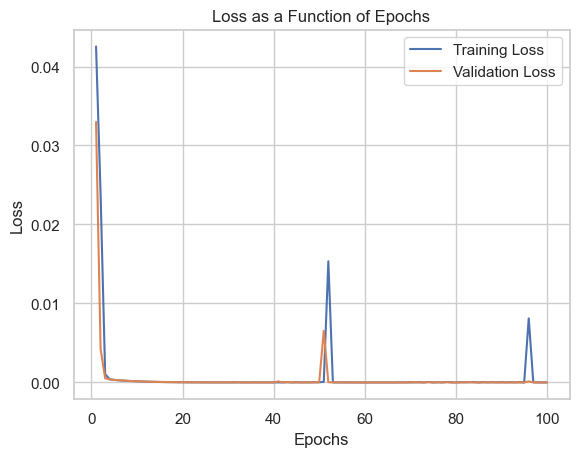

In [25]:
best_model_state, history = train_model(model=MODEL, 
                                        train_loader=train_loader, 
                                        val_loader=val_loader, 
                                        test_loader=test_loader, 
                                        optimizer=OPTIMIZER, 
                                        criterion=CRITERION, 
                                        num_epochs=NUM_EPOCHS, 
                                        model_save_path=MODEL_SAVE_PATH,
                                        writer_path=WRITER_PATH)

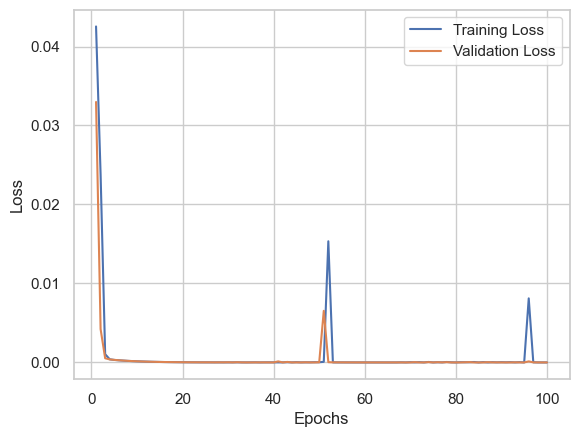

In [29]:
# plot the training and validation loss
figure_path = 'Figures/' + MODEL_NAME + '-loss.png'
epochs = range(1, len(history['train_loss']) + 1)
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(figure_path, dpi=300, bbox_inches='tight')
plt.show()

# save history as a pickel file:
history_path = 'History/' + MODEL_NAME + '-history.pkl'
with open(history_path, 'wb') as f:
    pkl.dump(history, f)

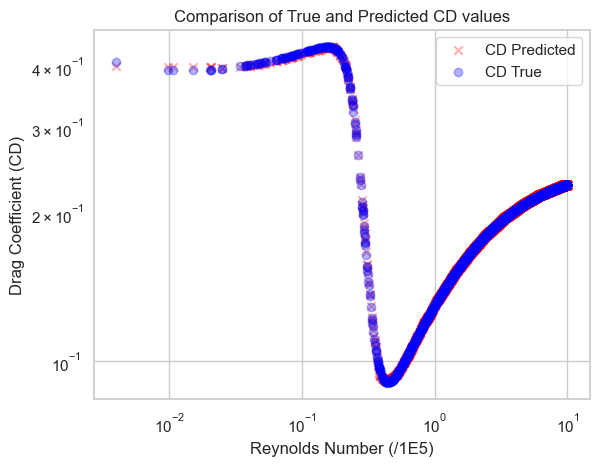

MSE: 0.00000, MAE: 0.00041


In [18]:
# Prediction:
DATASET_TEST = test_dataset
MODEL_SAVE_PATH = 'models/' + MODEL_NAME + '.pt'
predictions = predict_model(model_path=MODEL_SAVE_PATH, 
                            dataset=DATASET_TEST)

# Evaluation:
mse, mae = eval_model(DATASET_TEST, MODEL_SAVE_PATH, visualize=True)
print(f"MSE: {mse:.5f}, MAE: {mae:.5f}")


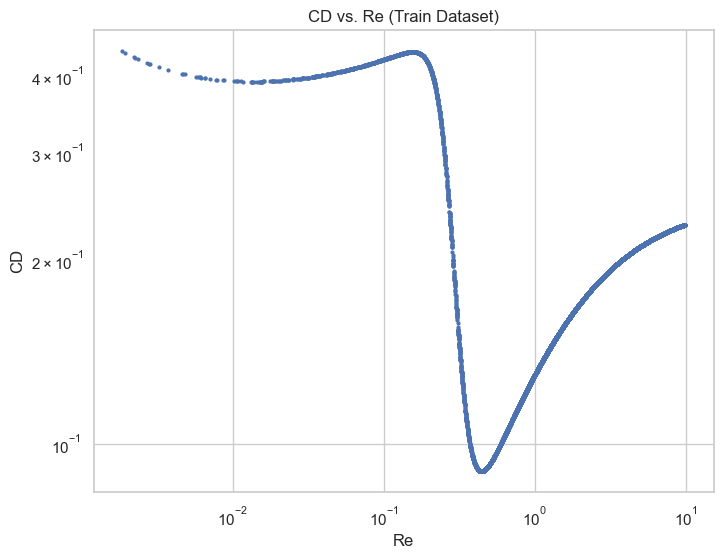

In [19]:
Re_list = []
CD_list = []

for input_sample, target in train_dataset:
    
    # Calculate Re using the re-scaled parameters
    Re = input_sample.item()
    CD = target.item()
    Re_list.append(Re)
    CD_list.append(CD)

plt.figure(figsize=(8, 6))
plt.loglog(Re_list, CD_list, 'o', markersize=2)
plt.xlabel('Re')
plt.ylabel('CD')
plt.title('CD vs. Re (Train Dataset)')
plt.grid(True)
plt.show()